# Compare simulation and mean field for Potjans' model


## Simulation

In [1]:
"""Further command line arguments:
        c       script will close all open plots
        sli     data of the original simulation written in sli will be analyzed. 
                Note that at this point, the data must be of the same simulation type, 
                as specifications are loaded from .npy-files of the pynest simulation. 

    Overview over all populations: Raster plot, mean rates, mean CV of ISI per population.
"""
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
# Close other plots by adding 'c'after 'run <script>' 
if 'c' in sys.argv:
    plt.close('all')
figure_path = "./figures"
######################################################
# Import specific moduls
import model_class; reload(model_class)
import helper_functions as hf; reload(hf)

%matplotlib inline

show_fig = False
save_fig = True
xfactor = 2.6
plt.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 6 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


In [2]:
# DATA
data_file = "micro"
data_sup_path = "/export/data-schuessler/data_microcircuit/"
data_path = os.path.join(data_sup_path, data_file)

sim_spec = "a1.0_t20.4_00"
data_file_name  = sim_spec + ".hdf5"  
res_file_name = sim_spec + "_res.hdf5"
path_data_file = os.path.join(data_path, data_file_name)
path_res_file = os.path.join(data_path, res_file_name)


# Basic data
with h5py.File(path_data_file, "r") as data_file:
    # Simulation attributes
    area    = data_file.attrs["area"]   
    t_sim   = data_file.attrs["t_sim"]  
    t_trans = data_file.attrs["t_trans"]
    dt      = data_file.attrs["dt"]    
    populations   = data_file.attrs["populations"].astype("|U4")
    layers        = data_file.attrs["layers"].astype("|U4")        
    types         = data_file.attrs["types"].astype("|U4")     
    n_populations = data_file.attrs["n_populations"]
    n_layers      = data_file.attrs["n_layers"]       
    n_types       = data_file.attrs["n_types"] 

    t_measure = t_sim - t_trans

    # labels & colors: need to be adapted if n_types != (e, i)
    layer_colors = style.colors[:n_layers]
    colors = np.array([color for color in layer_colors for i in range(n_types)])
    colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
    if reverse_order:
        populations = populations[::-1]
        layers = layers[::-1]
        types = types[::-1]
        colors = colors[::-1]

## Mean field model

In [3]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               root_function=None,
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root
    # Instantiation
    if jacobian:
        jac = model.jacobian
    else:
        jac = False

    # Run on initial guess v_guess_0
    if root_function=="siegert":
        sol = root(model.root_v0_siegert, v_guess_0, jac=jac, method=root_method, options=options)
    else:
        sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        print("intial success")
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")


### $C_{ab} = C_{micro}$ and $J_{02} = 2$

In [4]:
#######################################################
# Global boundaries
#######################################################
connection_rule = "fixed_indegree"
PSC_rel_sd      = 0.0
model_micro       = model_class.model(connection_rule=connection_rule,
                                           PSC_rel_sd=PSC_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
root_function = "siegert" # very slow and no difference...
root_function = None
jacobian=False
root_method='hybr'
options=None

t_int0      = time.time()
rate_mf = solve_model(model_micro, v_guess_0,
                root_function=root_function, jacobian=jacobian, root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

intial success
Integration time: 0.03


In [5]:
######################################################
# Simulation results
######################################################
with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all = np.zeros((n_sims, n_populations))
    rates_std_all = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"]
        rates_std_all[j]    = res_grp["rates_std"]

## With connection_rule = "fixed_total_number":

0
1
2
3
4
5
6
7
save figure to compare_sim_mf_fixed_total_number


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


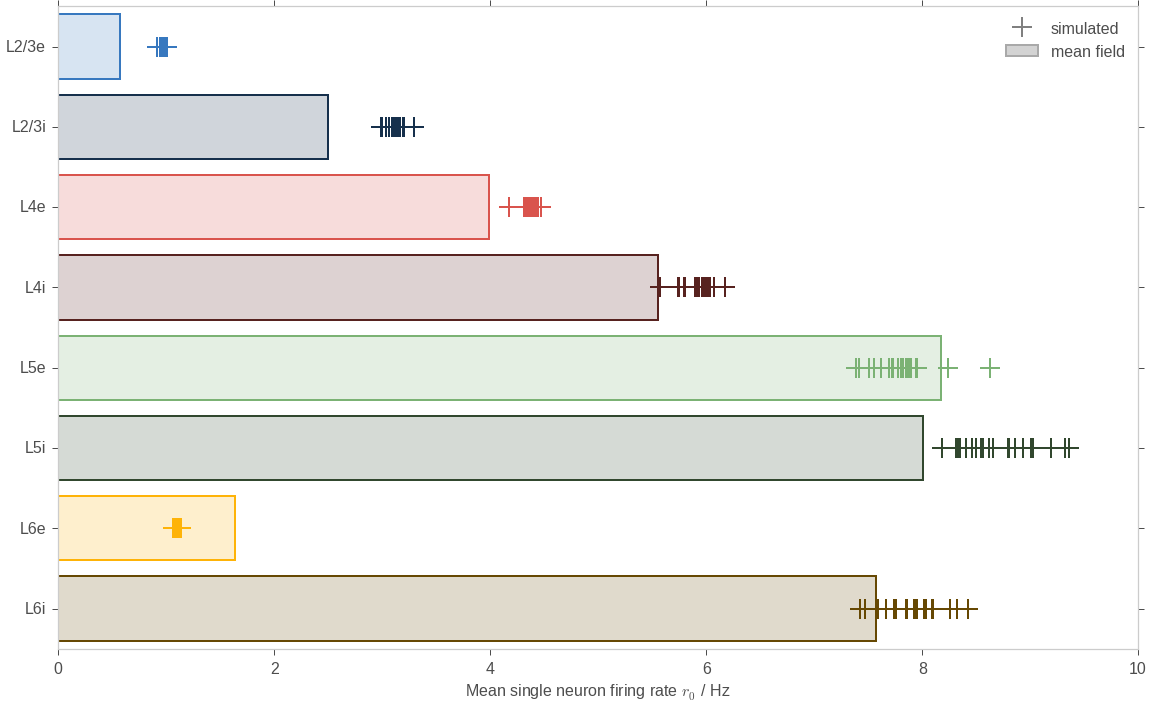

In [6]:
######################################################
# Plotting
######################################################
plot_pops=np.array(['L4e', 'L4i'])
plot_pops= populations    # These populations are plotted
if not type(plot_pops) == np.ndarray:
    plot_pops = np.array([plot_pops])
i_pop  = np.array([np.where(plot_pop == populations)[0][0] 
                   for plot_pop in plot_pops])

fig = plt.figure()

y_mf = np.arange(n_populations) + 0.1
yticks = np.arange(n_populations) + 0.5
bar_height = 0.8 
    
ax = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
for i, population in zip(i_pop, plot_pops):
    print(i)
    ax.plot(rates_mean_all[:, i], [yticks[i]]*rates_mean_all.shape[0], '+', color=colors[i], mew=2, ms=20)
    ax.barh(y_mf[i], rate_mf[::-1][i], height=bar_height, 
            color=colors[i], linewidth=0, fill=True, alpha=0.2) 
    ax.barh(y_mf[i], rate_mf[::-1][i], height=bar_height, 
            edgecolor=colors[i], linewidth=2, fill=False, alpha=1.0) 
ax.barh([0], [0], color="lightgray", edgecolor="darkgray", linewidth=2, fill=True, alpha=1.0, label="mean field") 
ax.plot([-1], [0], "+", color="gray", alpha=1.0, label="simulated", mew=2, ms=5) 

ax.set_xlabel("Mean single neuron firing rate $r_0$ / Hz")
ax.set_xlim(0, 10)
ax.set_yticks(yticks)
ax.set_yticklabels(hf.rlbl(populations))
ax.legend(loc="best")
ax.grid(False)

fig_name = "compare_sim_mf_fixed_total_number"
    
if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path, fig_name + ".pdf"), bbox_inches='tight', format="pdf")
    fig.savefig(os.path.join(figure_path, fig_name + ".png"), bbox_inches='tight', format="png")  

## With connection_rule = "fixed_indegree":

In [5]:
# DATA
data_file = "micro"
data_sup_path = "/export/data-schuessler/data_microcircuit/"
data_path = os.path.join(data_sup_path, data_file)

sim_spec = "a1.0_t20.2_fixindeg_01"

# Original data
data_file_name  = sim_spec + ".hdf5"  
res_file_name = sim_spec + "_res.hdf5"
path_data_file = os.path.join(data_path, data_file_name)
path_res_file = os.path.join(data_path, res_file_name)

In [6]:
######################################################
# Simulation results
######################################################
with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all = np.zeros((n_sims, n_populations))
    rates_std_all = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"]
        rates_std_all[j]    = res_grp["rates_std"]

0
1
2
3
4
5
6
7
save figure to compare_sim_mf_fixed_indegree


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


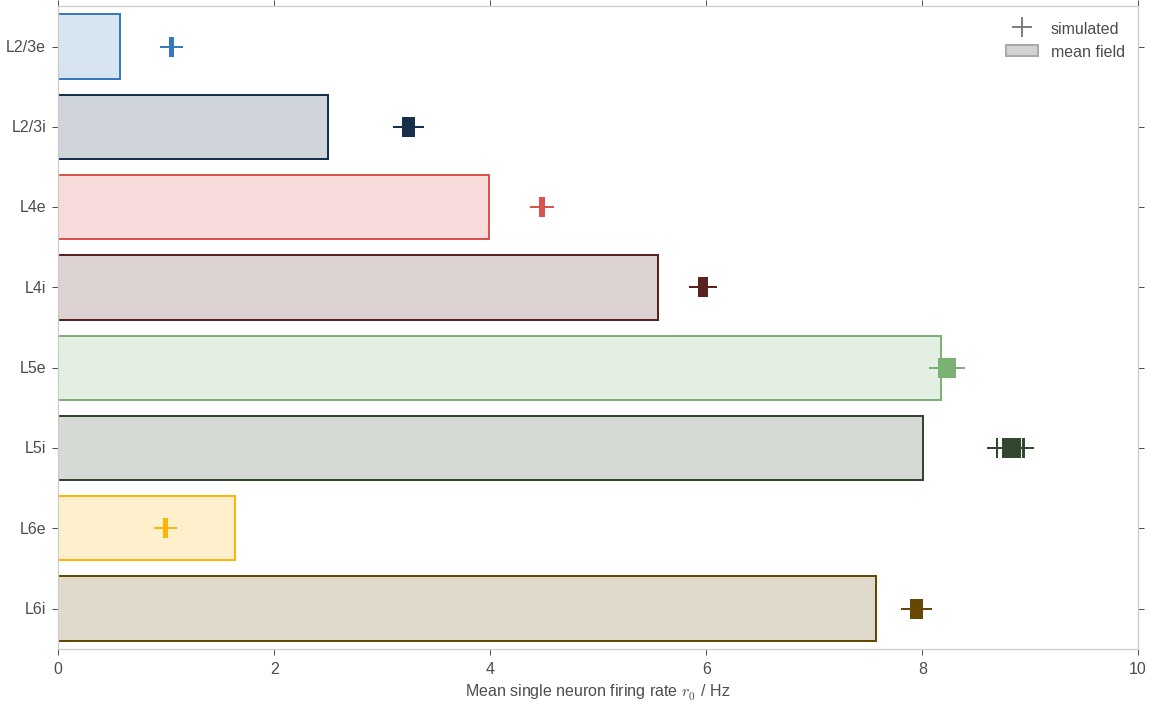

In [7]:
######################################################
# Plotting
######################################################
plot_pops=np.array(['L4e', 'L4i'])
plot_pops= populations    # These populations are plotted
if not type(plot_pops) == np.ndarray:
    plot_pops = np.array([plot_pops])
i_pop  = np.array([np.where(plot_pop == populations)[0][0] 
                   for plot_pop in plot_pops])

fig = plt.figure()
if not save_fig:
    suptitle = "Step by step transforming BrunelA to Microcircuit: transform $C_{ab}$" + \
        "\nmethod: " + root_method
    suptitle += "\nfile: " + sim_spec
    fig.suptitle(suptitle, y=0.98)

y_mf = np.arange(n_populations) + 0.1
yticks = np.arange(n_populations) + 0.5
bar_height = 0.8 
    
ax = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
for i, population in zip(i_pop, plot_pops):
    print(i)
    ax.plot(rates_mean_all[:, i], [yticks[i]]*rates_mean_all.shape[0], '+', color=colors[i], mew=2, ms=20)
    ax.barh(y_mf[i], rate_mf[::-1][i], height=bar_height, 
            color=colors[i], linewidth=0, fill=True, alpha=0.2) 
    ax.barh(y_mf[i], rate_mf[::-1][i], height=bar_height, 
            edgecolor=colors[i], linewidth=2, fill=False, alpha=1.0) 
ax.barh([0], [0], color="lightgray", edgecolor="darkgray", linewidth=2, fill=True, alpha=1.0, label="mean field") 
ax.plot([-1], [0], "+", color="gray", alpha=1.0, label="simulated", mew=2, ms=5) 

ax.set_xlabel("Mean single neuron firing rate $r_0$ / Hz")
ax.set_xlim(0, 10)
ax.set_yticks(yticks)
ax.set_yticklabels(hf.rlbl(populations))
ax.legend(loc="best")
ax.grid(False)

fig_name = "compare_sim_mf_fixed_indegree"
    
if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path, fig_name + ".pdf"), bbox_inches='tight', format="pdf")
    fig.savefig(os.path.join(figure_path, fig_name + ".png"), bbox_inches='tight', format="png")  

## Check $\mu$ and $\sigma$
### For consistency, and for the numerical stability of the algorithm applied...

In [10]:
mu_brunel = model_micro.mu(rate_mf[::-1])
sd_brunel = model_micro.sd(rate_mf[::-1])
mu_brunel, sd_brunel

(array([ 35.95056827,  41.19447994,   3.9172597 ,  20.65606839,
         50.05094192,  34.03839799,  40.74860721,  37.68801014]),
 array([ 5.8335019 ,  4.80950918,  5.48111228,  6.18623123,  4.504506  ,
         3.73627247,  3.47004715,  2.66128992]))